This notebook contains the code for my forest fire prediction regression project. The entire github repository can be found at https://github.com/grahamgreene88/Forest-Fire-Predicition. 

In [454]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Project Objective / Business Relevance

The objective of this project is to predict the area of forest firest that occured in Montesinho Natural Park in
Portugal. In recent years forest fires have become a large concern worlwide. Specifically here in Canada, the
recent forest fire season in the summer of 2023 resulted in large burn areas and unprecended smoky conditions across North America. 

Predicting the area of forest fires can be very useful for firefighting resource management and to help choose
which targets to prioritize with limited resources. This is relevant to future summers here in Canada with forest
fire occurences expected to increase in upcoming years due to increasing global temperatures.

## Exploratory Data Analysis

In [455]:
df = pd.read_csv('forestfires.csv')
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


The dataset contains 517 observations, 12 features and 1 target variable (area). The features fall into three categories:
- spacial coordinates: X and y spacial coordinates within Montesinho Park map.
- temporal variables: month and day of the week
- meteoroligical variables: temp, RH, wind, rain (FFMC, DMC, DC and ISI are components of the Canadian system for rating fire danger)

The target variable "area burned" is measured in hectares (ha) where 1 ha = 100 m^2. Values of zero mean that an area lower than 1 ha was burned.

In [456]:
df.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

There are no missing values in this dataset.

In [457]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


The output above shows the range of each variable. The range of the target variable (area) is important to note
here, with a min of 0 a max of 1091 and a mean of only 12.85. Let's checkout the distribution:

In [458]:
zero_obs = len(df[df['area'] == 0])
print(f"There are {zero_obs} observations with a burn area of 0 ha. That is almost half of the dataset.")

There are 247 observations with a burn area of 0 ha. That is almost half of the dataset.


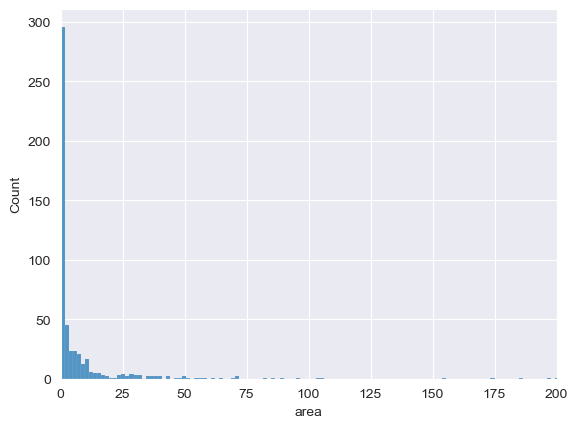

In [459]:
# Plotting distribution of target variable, area
sns.histplot(data=df, x='area')
sns.set_style('darkgrid')
plt.xlim(0, 200)
plt.show()

Target variable distribution is clearly heavily right-skewed. This is due to all the observations with zero area (less than 1 ha). To improve the skewness, the log(1+x) function will be applid to all target variable values. This transformation can help improve regression results for right-skewed target variables.

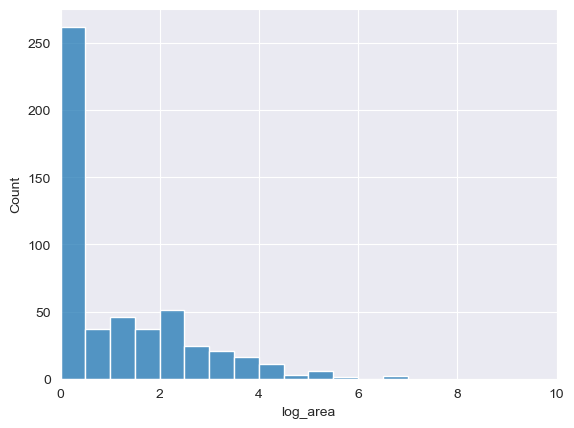

In [460]:
# Applying log(1+x) transformation to area column
df['log_area'] = np.log1p(df['area'])
df = df.drop('area', axis=1)
# Plotting the transformed distribution
sns.histplot(data=df, x='log_area')
sns.set_style('darkgrid')
plt.xlim(0, 10)
plt.show()

Target variable is still right-skewed but less so. This will hopefully improve regression performance.

In [461]:
# Displaying feature data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X         517 non-null    int64  
 1   Y         517 non-null    int64  
 2   month     517 non-null    object 
 3   day       517 non-null    object 
 4   FFMC      517 non-null    float64
 5   DMC       517 non-null    float64
 6   DC        517 non-null    float64
 7   ISI       517 non-null    float64
 8   temp      517 non-null    float64
 9   RH        517 non-null    int64  
 10  wind      517 non-null    float64
 11  rain      517 non-null    float64
 12  log_area  517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


All data types are in numeric format except the month and day of the week columns. The categorical variables will be encoded and the numerical features will be scaled to ensure they are suitable for a range of model types. For scaling, the numeric variables will be standardized so each one has a mean of 0 and unit variance.

**Note: the data will be separated into train and test sets at this point to avoid information leakage. Without this split, information from the test set would be learned during feature scaling which could artificially improve performance on unseen data (test set).**

In [462]:
# Separating features and target variable
X = df.drop('log_area', axis=1)
y = df['log_area']
# Performing train_test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=10)

In [463]:
# Standardizing data
from sklearn.preprocessing import StandardScaler
# Standardizing numeric features of train set
scaler = StandardScaler()
numeric_cols = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
scaler.fit(X_train[numeric_cols])
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])

The test set will now be standardized using the scaler fit on the train set (it is important that the scaler is not fit on the test set here to prevent information leakge)

In [464]:
# Standardizing test set with scaler fit on train set
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
X_test.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,-0.057956,-0.138343,0.071984,-0.173326,-0.066123,-0.003282,-0.035793,-0.099121,0.144928,0.344584
std,1.013235,0.889505,0.791126,0.880904,0.983438,0.830910,1.084417,1.095393,1.204455,5.252061
min,-1.606171,-1.858708,-6.926885,-1.675798,-2.155849,-1.817110,-2.594067,-1.865745,-1.802310,-0.116052
25%,-1.063962,-0.272556,-0.019810,-0.951154,-0.507274,-0.458319,-0.649438,-1.032957,-0.740675,-0.116052
50%,-0.304870,-0.272556,0.200216,-0.132934,0.317767,-0.089655,0.028103,-0.357298,0.026061,-0.116052
75%,0.996431,0.520520,0.390042,0.338750,0.619790,0.415941,0.639649,0.396926,0.851777,-0.116052
max,1.863966,1.313596,0.959520,2.473501,1.096521,2.880724,2.527084,3.099560,3.210965,59.766662


It is seen above that the features are not perfectly scaled to mean of 0 and std dev. of 1. This is a consequence of transforming the unseen data using a scaler fit on the seen data and properly mimics real-world conditions.

In [465]:
# Creating function to encode data
def encode(df):
    # Encoding categorical variables
    df_encoded = pd.get_dummies(df, drop_first=True)
    col = df_encoded.select_dtypes(include='bool').columns
    df_encoded[col] = df_encoded[col].astype('int')
    return df_encoded

In [466]:
# Encoding cat variables of train and test set
X_train = encode(X_train)
X_test = encode(X_test)
print(f"Train set features: {X_train.columns}.")
print(f"Train set features: {X_test.columns}.")

Train set features: Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue',
       'day_wed'],
      dtype='object').
Train set features: Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'month_aug', 'month_dec', 'month_feb', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_oct', 'month_sep', 'day_mon',
       'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed'],
      dtype='object').


The train set has more features than the test set. This is due to a small number of fires that occured during the winter months that all ended up in the test set. These observations will be removed along with the corresponding features to ensure feature consistency. The months are January and November.

In [467]:
# Counting observations that occur in jan and nov
nov_cols = X_train[X_train['month_jan'] != 0]
jan_cols = X_train[X_train['month_nov'] != 0]
print(f"There are {len(nov_cols) + len(jan_cols)} observations that occured in November or January.")

There are 3 observations that occured in November or January.


In [468]:
X_train.shape

(387, 27)

In [469]:
# Dropping 3 observations in these months
nov_index = X_train.index[X_train['month_jan'] != 0]
jan_index = X_train.index[X_train['month_nov'] != 0]
X_train.drop(nov_index, axis=0, inplace=True)
X_train.drop(jan_index, axis=0, inplace=True)
X_train.shape

(384, 27)

In [470]:
# Dropping nov and jan features (which now contain only zeros)
cols_to_drop = ['month_nov', 'month_jan']
X_train.drop(cols_to_drop, axis=1, inplace=True)
X_train.shape

(384, 25)

In [471]:
# Ensuring train and test sets now contains same number of features
assert len(X_train.columns) == len(X_test.columns)

## Modeling

Cross validation will be performed for several different models using their default parameters and evaluated using root mean squared error (MSE). The hyperparameters of the best performing model will then be optimized.

In [ ]:
# Importing models and cross-validation
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.SVM import SVR
from sklea
